In [1]:
import os
from glob import glob
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import mne
mne.set_log_level(verbose=False)
import wandb
from tqdm.auto import tqdm

from Datasets import *

C:\Users\vila_\anaconda3\envs\Master\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vila_\anaconda3\envs\Master\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\vila_\anaconda3\envs\Master\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
config = {
    'epochs':10,
    'classes':5,
    'batch_size':32,
    'learning_rate':3e-4,
    'channels':['F4'],
    'patients_train':1,
    'patients_test':2,
    'binary':False,
    'metadata': "Test Normalización en memoria"
}

In [3]:
dataset1 = EDFData(path="../Data/PSG1.edf", channels=config["channels"], binary=False)
dataset2 = EDFData(path="../Data/PSG2.edf", channels=config["channels"], binary=False)

In [4]:
data1 = dataset1.epochs.get_data()
data2 = dataset2.epochs.get_data()
data1.shape, data2.shape

((882, 1, 15360), (840, 1, 15360))

In [5]:
data1 = np.squeeze(data1, axis=1)
data2 = np.squeeze(data2, axis=1)
data1.shape, data2.shape

((882, 15360), (840, 15360))

In [6]:
labels1 = dataset1.epochs.events[:,-1]
labels2 = dataset2.epochs.events[:,-1]
labels1.shape, labels2.shape

((882,), (840,))

In [7]:
print(dataset1.epochs.event_id)
print(dataset2.epochs.event_id)

{'Sleep stage N1': 1, 'Sleep stage N2': 2, 'Sleep stage N3': 3, 'Sleep stage R': 4, 'Sleep stage W': 5}
{'Sleep stage N1': 1, 'Sleep stage N2': 2, 'Sleep stage N3': 3, 'Sleep stage R': 4, 'Sleep stage W': 5}


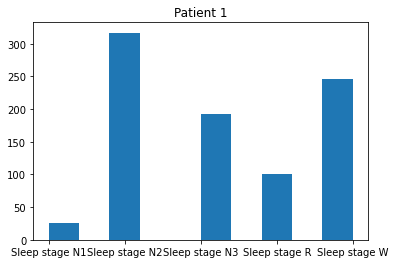

In [8]:
plt.hist(labels1)
plt.title("Patient 1")
plt.xticks(list(dataset1.epochs.event_id.values()), dataset1.epochs.event_id.keys())
plt.show()

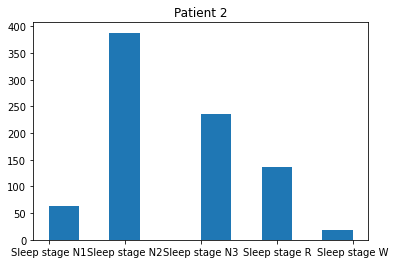

In [9]:
plt.hist(labels2)
plt.title("Patient 2")
plt.xticks(list(dataset2.epochs.event_id.values()), dataset2.epochs.event_id.keys())
plt.show()

## Obtain mean and std per channel (as of now we only have one channel so it should be easy)

In [10]:
mean1 = data1.mean()
std1 = data1.std()
mean1, std1

(2.941610868569235e-05, 0.0001535793839162135)

In [11]:
mean2 = data2.mean()
std2 = data2.std()
mean2, std2

(2.6143434005411677e-05, 0.00020400647906862842)

In [12]:
import scipy.stats as stats

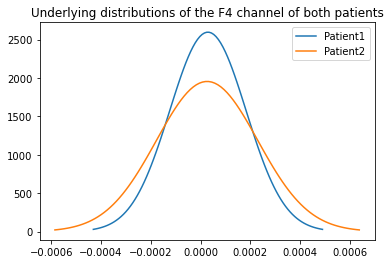

In [13]:
x = np.linspace(mean1 - 3*std1, mean1 + 3*std1, 100)
plt.plot(x, stats.norm.pdf(x, mean1, std1), label='Patient1')
x = np.linspace(mean2 - 3*std2, mean2 + 3*std2, 100)
plt.plot(x, stats.norm.pdf(x, mean2, std2), label='Patient2')
plt.legend()
plt.title("Underlying distributions of the F4 channel of both patients")
plt.show()

## Plot raw channel distribution and standarized

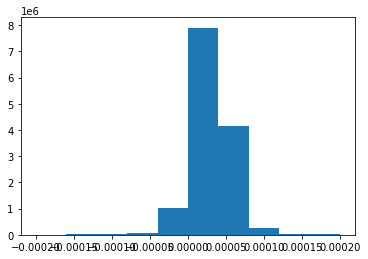

In [14]:
plt.hist(data1.flatten(), range=[-0.0002, 0.0002])
plt.show()

In [15]:
data1_std = (data1 - mean1)/std1
data2_std = (data2 - mean2)/std2

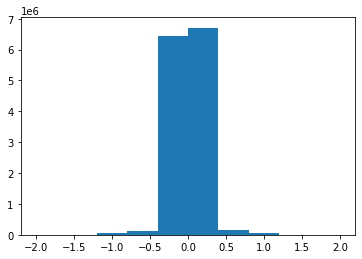

In [16]:
plt.hist(data1_std.flatten(), range=[-2,2])
plt.show()

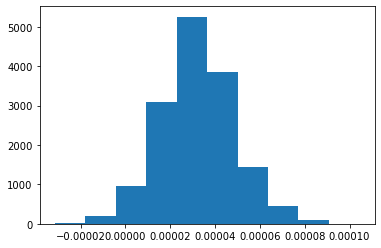

In [17]:
plt.hist(data1[0])
plt.show()

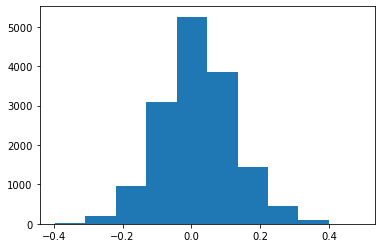

In [18]:
plt.hist(data1_std[0])
plt.show()

## First normalize each channel in itself and then std

In [19]:
np.abs(data1).max(axis=1).shape

(882,)

In [20]:
data1_norm = data1 / np.expand_dims(np.abs(data1).max(axis=1),-1)
data2_norm = data2 / np.expand_dims(np.abs(data2).max(axis=1),-1)

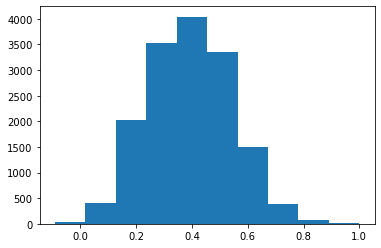

In [21]:
plt.hist(data1_norm[99])
plt.show()

In [22]:
data1_norm_std = (data1_norm - data1_norm.mean())/data1_norm.std()
data2_norm_std = (data2_norm - data2_norm.mean())/data2_norm.std()

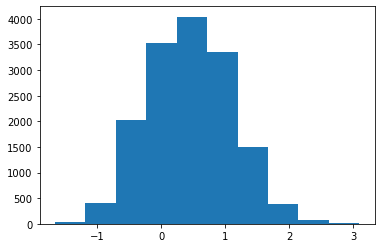

In [23]:
plt.hist(data1_norm_std[99])
plt.show()

In [24]:
data1_norm_nomean = (data1_norm - np.expand_dims(data1_norm.mean(axis=1),-1))
data2_norm_nomean = (data2_norm - np.expand_dims(data2_norm.mean(axis=1),-1))

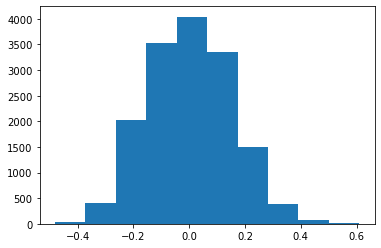

In [25]:
plt.hist(data1_norm_nomean[99])
plt.show()

## Testing with simple models

In [26]:
import tensorflow as tf

In [28]:
sampling_rate = 512

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=sampling_rate//2, strides=sampling_rate//4, activation="relu", input_shape=(15360,1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(config['classes'], activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 119, 128)          32896     
_________________________________________________________________
flatten_5 (Flatten)          (None, 15232)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 76165     
Total params: 109,061
Trainable params: 109,061
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model.fit(np.expand_dims(data1_norm_nomean, axis=-1), labels1-1, batch_size=16, epochs=10)

Epoch 1/10
56/56 [==============================] - 0s 3ms/step - loss: 1.4530 - accuracy: 0.3322
Epoch 2/10
56/56 [==============================] - 0s 4ms/step - loss: 1.2861 - accuracy: 0.4649
Epoch 3/10
56/56 [==============================] - 0s 3ms/step - loss: 1.0900 - accuracy: 0.5454
Epoch 4/10
56/56 [==============================] - 0s 3ms/step - loss: 0.9084 - accuracy: 0.6202
Epoch 5/10
56/56 [==============================] - 0s 3ms/step - loss: 0.8019 - accuracy: 0.6633
Epoch 6/10
56/56 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.7506
Epoch 7/10
56/56 [==============================] - 0s 4ms/step - loss: 0.5609 - accuracy: 0.7902
Epoch 8/10
56/56 [==============================] - 0s 3ms/step - loss: 0.4645 - accuracy: 0.8401
Epoch 9/10
56/56 [==============================] - 0s 3ms/step - loss: 0.4638 - accuracy: 0.8356
Epoch 10/10
56/56 [==============================] - 0s 3ms/step - loss: 0.3343 - accuracy: 0.8957


### Direct Comparisons

In [27]:
def create_simple_model(sampling_rate, classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(128, kernel_size=sampling_rate//2, strides=sampling_rate//4, activation="relu", input_shape=(15360,1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [40]:
data_to_try = {
    "Raw Data":[data1, data2],
    "Standarized Data":[data1_std, data2_std],
    "Normalized Data":[data1_norm, data2_norm],
    "Normalized and Standarized Data":[data1_norm_std, data2_norm_std],
    "Normalized and Mean Substracted Data":[data1_norm_nomean, data2_norm_nomean]
}

In [46]:
histories = {}
for name, data in tqdm(data_to_try.items()):
    data_train, data_test = data
    model = create_simple_model(512, config["classes"])
    history = model.fit(np.expand_dims(data_train, axis=-1), labels1-1, batch_size=16, epochs=50, verbose=0, validation_data=(np.expand_dims(data_test, axis=-1), labels2-1))
    histories[name] = history

100%|██████████| 5/5 [00:58<00:00, 11.71s/it]


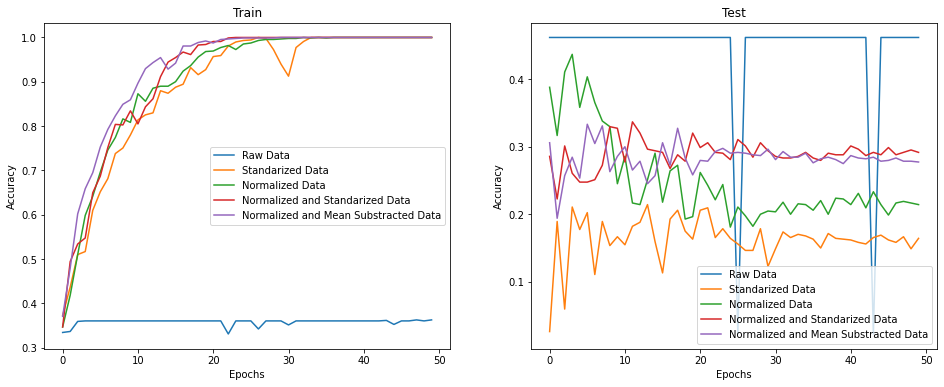

In [47]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("Train")

for i, (name, history) in enumerate(histories.items()):
    plt.plot(history.history["accuracy"], label=name)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.title("Test")

for i, (name, history) in enumerate(histories.items()):
    plt.plot(history.history["val_accuracy"], label=name)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()

### It'd be nice to see how many patients at the same time can it learn (so far it can memo the first one)

In [28]:
np.concatenate([data1, data2]).shape

(1722, 15360)

In [29]:
data_to_try = {
    "Raw Data":np.concatenate([data1, data2]),
    "Standarized Data":np.concatenate([data1_std, data2_std]),
    "Normalized Data":np.concatenate([data1_norm, data2_norm]),
    "Normalized and Standarized Data":np.concatenate([data1_norm_std, data2_norm_std]),
    "Normalized and Mean Substracted Data":np.concatenate([data1_norm_nomean, data2_norm_nomean])
}

In [31]:
labels12 = np.concatenate([labels1, labels2])
labels12.shape

(1722,)

In [32]:
histories = {}
for name, data in tqdm(data_to_try.items()):
    data_train, data_test = data, data
    model = create_simple_model(512, config["classes"])
    history = model.fit(np.expand_dims(data_train, axis=-1), labels12-1, batch_size=16, epochs=50, verbose=0, validation_data=(np.expand_dims(data_test, axis=-1), labels12-1))
    histories[name] = history

100%|██████████| 5/5 [02:08<00:00, 25.74s/it]


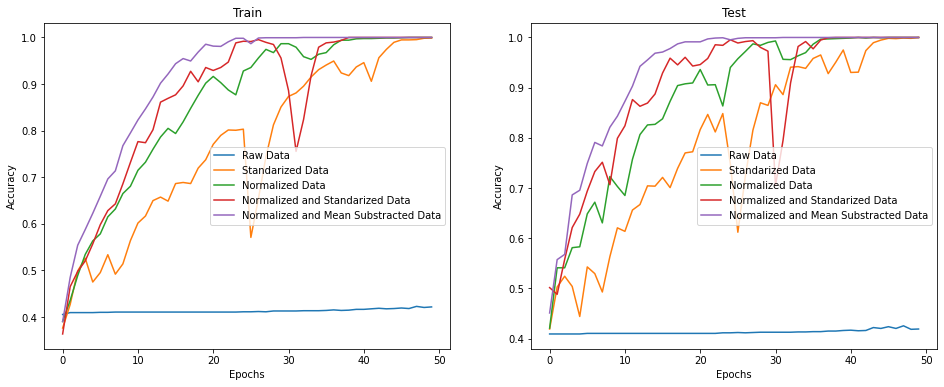

In [33]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("Train")

for i, (name, history) in enumerate(histories.items()):
    plt.plot(history.history["accuracy"], label=name)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.title("Test")

for i, (name, history) in enumerate(histories.items()):
    plt.plot(history.history["val_accuracy"], label=name)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()

## Creating a neat loop

In [38]:
def load_data(path):
    dataset = EDFData(path=path, channels=config["channels"], binary=False)
    data = dataset.epochs.get_data()
    data = np.squeeze(data, axis=1)
    labels = dataset.epochs.events[:,-1]

    return data, labels

In [36]:
def create_scaled_data(data):
    ## Obtain mean and std
    mean = data.mean()
    std = data.std()

    ## Create different data
    data_std = (data - mean)/std
    data_norm = data / np.expand_dims(np.abs(data).max(axis=1),-1)
    data_norm_std = (data_norm - data_norm.mean())/data_norm.std()
    data_norm_nomean = (data_norm - np.expand_dims(data_norm.mean(axis=1),-1))

    ## Put them into a dictionary so its more clean
    scaled_data = {
        "Raw Data":data,
        "Standarized Data":data_std,
        "Normalized Data":data_norm,
        "Normalized and Standarized Data":data_norm_std,
        "Normalized and Mean Substracted Data":data_norm_nomean
    }

    return scaled_data
    

In [43]:
def train_scaled_data(scaled_data, labels, epochs=50):
    histories = {}

    ## Train a model for each different scaled data and store the History object
    for name, data in tqdm(scaled_data.items()):
        model = create_simple_model(512, config["classes"])
        history = model.fit(np.expand_dims(data, axis=-1), labels, batch_size=16, epochs=epochs, verbose=0)
        histories[name] = history
    
    return histories

In [37]:
def plot_histories(histories, n_patients):    
    plt.figure(figsize=(16,6))
    plt.suptitle(f"{n_patients} Patients")
    plt.subplot(1,2,1)
    plt.title("Loss")

    for i, (name, history) in enumerate(histories.items()):
        plt.plot(history.history["loss"], label=name)

    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Accuracy")

    for i, (name, history) in enumerate(histories.items()):
        plt.plot(history.history["accuracy"], label=name)

    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.show()

### Pipeline try

In [39]:
path = "../Data/PSG1.edf"

100%|██████████| 5/5 [04:59<00:00, 59.97s/it]


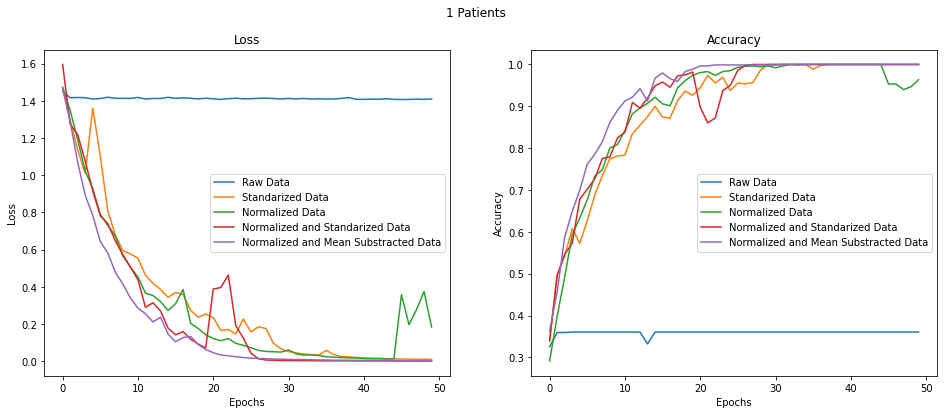

In [47]:
data, labels = load_data(path)
scaled_data = create_scaled_data(data)
histories = train_scaled_data(scaled_data, labels-1, epochs=50) # Very important -1 so that labels are [0,4] and not [1,5]
plot_histories(histories,1)

100%|██████████| 5/5 [04:42<00:00, 56.47s/it]


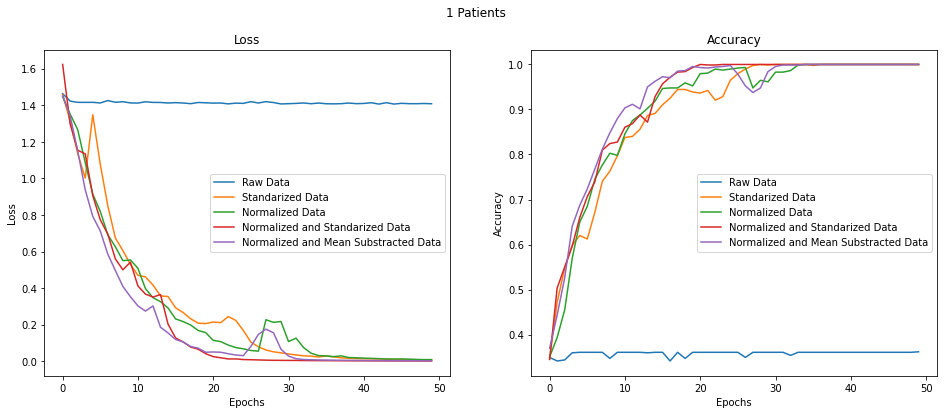

100%|██████████| 5/5 [08:48<00:00, 105.80s/it]


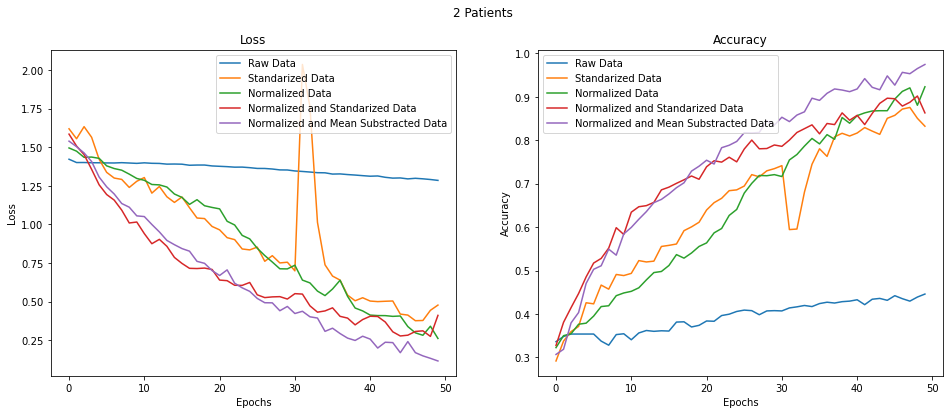

100%|██████████| 5/5 [12:37<00:00, 151.45s/it]


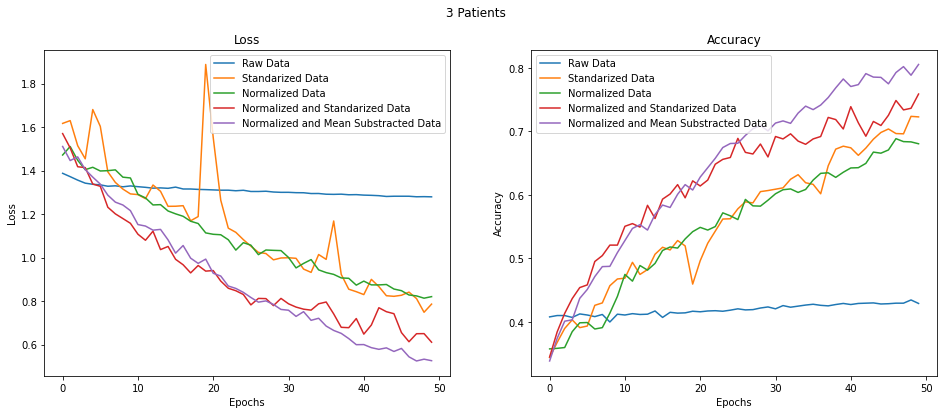

100%|██████████| 5/5 [16:06<00:00, 193.29s/it]


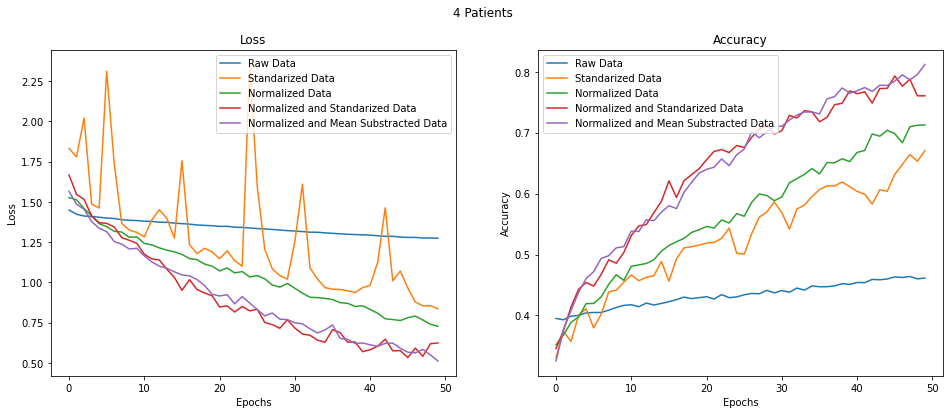

 60%|██████    | 3/5 [14:30<09:40, 290.22s/it]


KeyboardInterrupt: 

In [66]:
patients = []
for i, path in enumerate(glob("../Data/*.edf"), 1):
    
    if i > 1: # If it's not the first iteration
        ## Obtain new data
        data, labels_new = load_data(path)
        scaled_data_new = create_scaled_data(data)
        ## Concat new data to last data
        scaled_data = {key:np.concatenate([value, scaled_data_new[key]]) for key, value in scaled_data.items()}
        labels = np.concatenate([labels, labels_new])

    else:
        data, labels = load_data(path)
        scaled_data = create_scaled_data(data)

    histories = train_scaled_data(scaled_data, labels-1, epochs=50) # Very important -1 so that labels are [0,4] and not [1,5]
    plot_histories(histories, n_patients=i)

    # if i == 2:
    #     break